# NLP Classification - Linear Regression

In [120]:
import pandas as pd
import numpy as np

# Visualization library
%matplotlib inline
import matplotlib.pyplot as plt

# NLP libraries
import nltk, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

## Statistical modeling libraries
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import set_config

## Data Aquisition

Overall dataset schema:

reviewText: Text of the review<BR>
summary: Summary of the review<BR>
verified: Whether the purchase was verified (True or False)<BR>
time: UNIX timestamp for the review<BR>
rating: Rating of the review<BR>
log_votes: Logarithm-adjusted votes log(1+votes)<BR>

In [27]:
# Read training data
df = pd.read_csv('../data/classify/AMAZON-REVIEW-DATA-REGRESSION.csv')
df.head()

,reviewText,summary,verified,time,rating,log_votes
0,"Stuck with this at work, slow and we still got...",Use SEP or Mcafee,False,1464739200,1.0,0.0
1,I use parallels every day with both my persona...,Use it daily,False,1332892800,5.0,0.0
2,Barbara Robbins\n\nI've used TurboTax to do ou...,Helpful Product,True,1398816000,4.0,0.0
3,I have been using this software security for y...,Five Stars,True,1430784000,5.0,0.0
4,If you want your computer hijacked and slowed ...,... hijacked and slowed to a crawl Windows 10 ...,False,1508025600,1.0,0.0


##  EDA - Exploratory Data Analysis

In [28]:
print('Number of observations {} in the dataset. Number of features {}'.format(df.shape[0], df.shape[1]))

Number of observations 55000 in the dataset. Number of features 6


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55000 entries, 0 to 54999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewText  54994 non-null  object 
 1   summary     54993 non-null  object 
 2   verified    55000 non-null  bool   
 3   time        55000 non-null  int64  
 4   rating      55000 non-null  float64
 5   log_votes   55000 non-null  float64
dtypes: bool(1), float64(2), int64(1), object(2)
memory usage: 2.2+ MB


In [30]:
'''
    There are some null values in 'reviewText' & 'summary'
'''
if (df.isna().sum().sum() > 0 ):
    print("There are null values in the dataset")
else: print("There are NO null values in the dataset")

There are null values in the dataset


In [46]:
'''
Rows with null values in reviewText
'''
df[df["reviewText"].isnull()]

,reviewText,summary,verified,time,rating,log_votes
15956,NaN,Five Stars,True,1426809600,5.0,0.0
16567,NaN,What is there to say - it's like car insurance...,True,1522368000,5.0,0.0
26702,NaN,Five Stars,True,1505606400,5.0,0.0
40055,NaN,Five Stars,True,1522627200,5.0,0.0
43862,NaN,Five Stars,True,1463011200,5.0,0.0
51001,NaN,One Star,True,1510185600,1.0,0.0


In [47]:
'''
Rows with null values in summary
'''
df[df["summary"].isnull()]


,reviewText,summary,verified,time,rating,log_votes
6880,Five stars,NaN,True,1481932800,5.0,0.000000
7928,Microsoft Publisher 2002 contains new features...,NaN,False,1015459200,4.0,3.663562
9669,The devil you know is better than the devil yo...,NaN,True,1386633600,3.0,0.000000
14842,"Software is Cool , but over time a corrupted F...",NaN,True,1466035200,2.0,0.000000
33347,I know little about computers. I wanted to be ...,NaN,True,1188345600,5.0,0.000000
50928,This is an amazing game. I would give it 10 st...,NaN,False,1465603200,5.0,0.000000
53368,The app stalls and pauses. I was very disappo...,NaN,True,1438128000,2.0,0.000000


In [38]:
df.describe()

,time,rating,log_votes
count,5.500000e+04,55000.000000,55000.000000
mean,1.369527e+09,3.568018,0.529112
std,1.150230e+08,1.626900,0.960084
min,9.427104e+08,1.000000,0.000000
25%,1.322676e+09,2.000000,0.000000
50%,1.405382e+09,4.000000,0.000000
75%,1.448064e+09,5.000000,1.098612
max,1.537142e+09,5.000000,7.799753


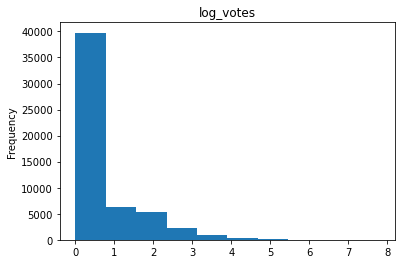

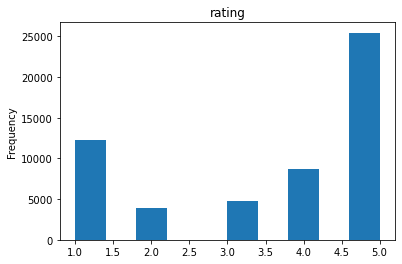

In [35]:
'''
'''
df["log_votes"].plot.hist()
plt.title("log_votes")
plt.show()

df["rating"].plot.hist()
plt.title('rating')
plt.show()

## Text Processing: Stop words removal and stemming 

In [51]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/lalithap/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lalithap/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Preparation

In [55]:
# Let's get a list of stop words from the NLTK library
stop = stopwords.words('english')

# These words are important for our problem. We don't want to remove them.
excluding = ['against', 'not', 'don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't",
             'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 
             'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't",
             'needn', "needn't",'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', 
             "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# New stop word list
stop_words = [word for word in stop if word not in excluding]

snow = SnowballStemmer('english')

def process_text(texts): 
    final_text_list=[]
    for sent in texts:
        
        # Check if the sentence is a missing value
        if isinstance(sent, str) == False:
            sent = ""
            
        filtered_sentence=[]
        
        sent = sent.lower() # Lowercase 
        sent = sent.strip() # Remove leading/trailing whitespace
        sent = re.sub('\s+', ' ', sent) # Remove extra space and tabs
        sent = re.compile('<.*?>').sub('', sent) # Remove HTML tags/markups:
        
        for w in word_tokenize(sent):
            # We are applying some custom filtering here, feel free to try different things
            # Check if it is not numeric and its length>2 and not in stop words
            if(not w.isnumeric()) and (len(w)>2) and (w not in stop_words):  
                # Stem and add to filtered list
                filtered_sentence.append(snow.stem(w))
        final_string = " ".join(filtered_sentence) #final string of cleaned words
 
        final_text_list.append(final_string)
        
    return final_text_list

In [58]:
X_train, X_val, y_train, y_val = train_test_split(df[["reviewText", "summary", "time", "rating"]],
                                                  df["log_votes"],
                                                  test_size=0.10,
                                                  shuffle=True,
                                                  random_state=324
                                                 )

'''
    Process reviewText and summary fields
'''
print("Processing the reviewText fields")
X_train["reviewText"] = process_text(X_train["reviewText"].tolist())
X_val["reviewText"] = process_text(X_val["reviewText"].tolist())

print("Processing the summary fields")
X_train["summary"] = process_text(X_train["summary"].tolist())
X_val["summary"] = process_text(X_val["summary"].tolist())

## Data processing with pipeline

In [81]:
lst_num = ['time', 'rating']
lst_text = ['summary', 'reviewText']
model_features = lst_num + lst_text

In [96]:
# Setup preprocessing pipeline
num_pipeline = Pipeline([ ('num_scaler', MinMaxScaler())])
text0_pipeline = Pipeline([ ('text_vect_0', CountVectorizer(binary=True, max_features=50))])
text1_pipeline = Pipeline([ ('text_vect_1', CountVectorizer(binary=True, max_features=150))])

# build preprocessor pipeline
model_preprocessor = ColumnTransformer([
    ('numerical_pre', num_pipeline, lst_num),
    ('text_pre_0', text0_pipeline, lst_text[0]),
    ('text_pre_1', text1_pipeline, lst_text[1])
]) 

# build pipeline an the estimator(linear_regression)
pipeline = Pipeline([ 
                ('data_preprocessing', model_preprocessor),
                ('lr', LinearRegression())            
                    ])

In [97]:
# Visualize the pipeline
set_config(display='diagram')
pipeline
        

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['time', 'rating']),
                                                 ('text_pre_0',
                                                  Pipeline(steps=[('text_vect_0',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=50))]),
                                                  'summary'),
                                                 ('text_pre_1',
                                                  Pipeline(steps=[('text_vect_1',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=150))]),
                                                  'reviewText')])),
                ('lr', LinearRegression())])

## Run Linera Regression model

In [99]:
# Train the linear regresssion model
pipeline.fit(X_train[model_features], y_train.values)

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['time', 'rating']),
                                                 ('text_pre_0',
                                                  Pipeline(steps=[('text_vect_0',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=50))]),
                                                  'summary'),
                                                 ('text_pre_1',
                                                  Pipeline(steps=[('text_vect_1',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=150))]),
                                                  'reviewText')])),
                ('lr', LinearRegression())])

## Fit a Linear Regression Model  

In [102]:
lrRegressor_val_predictions = pipeline.predict(X_val[model_features])
print("LinearRegression on Validation: Mean_squared_error: %f,  R_square_score: %f" % \
      (mean_squared_error(y_val, lrRegressor_val_predictions),r2_score(y_val, lrRegressor_val_predictions)))
print("LinearRegression model weights: \n", pipeline.named_steps['lr'].coef_)

LinearRegression on Validation: Mean_squared_error: 0.591002,  R_square_score: 0.356090
LinearRegression model weights: 
 [-1.74577245e+00 -4.16698701e-01  6.55478178e-02 -2.35272593e-02
  8.61182131e-02 -1.01365633e-02  7.93570945e-02  1.00553640e-01
  5.29775831e-02  2.05177281e-02  5.73231394e-02  2.22065172e-01
  9.93801547e-02 -1.37718548e-02 -4.06337520e-02 -1.06058044e-04
  4.40533068e-02  9.05416155e-02  2.17865285e-02  1.26157732e-02
 -2.25996290e-02  8.55590045e-03  2.45830786e-02 -2.33422376e-02
 -3.30934185e-02 -9.93257139e-03 -1.51382180e-01 -3.76458290e-02
  6.49464626e-02 -1.17080185e-02  1.08904257e-02  1.58619482e-02
 -4.96701342e-02 -5.60326946e-02  5.79966948e-02 -8.74212067e-02
  1.68585024e-02 -4.05427014e-02  2.67941228e-02  4.66072213e-02
 -9.31192091e-03  1.16266401e-01  2.62079452e-02 -2.14293911e-02
 -1.19377759e-02 -4.02070689e-02 -5.45584229e-02 -1.20253346e-01
  1.28724716e-02  5.21390342e-02 -1.36309572e-02  8.86498675e-02
  5.41902813e-03 -4.70436894e-02 

## Fit Ridge Model ( Linear Regression with L2 regularization)

In [104]:
# Let's update the pipeline with Ridge regression model
ridge_pipeline = Pipeline([
    ('data_preprocessing', model_preprocessor),
    ('ridge', Ridge(alpha = 100))
])

ridge_pipeline.fit(X_train[model_features], y_train.values)
ridgeRegressor_val_predictions = ridge_pipeline.predict(X_val[model_features])

print("Ridge on Validation: Mean_squared_error: %f,  R_square_score: %f" % \
      (mean_squared_error(y_val, ridgeRegressor_val_predictions),r2_score(y_val, ridgeRegressor_val_predictions)))

print("Ridge model weights: \n", ridge_pipeline.named_steps['ridge'].coef_)

Ridge on Validation: Mean_squared_error: 0.589703,  R_square_score: 0.357506
Ridge model weights: 
 [-1.62648079e+00 -4.04075727e-01  5.80555136e-02 -2.25636900e-02
  7.87477589e-02 -1.08407800e-02  5.89973415e-02  8.22764393e-02
  4.35481972e-02  1.30580769e-02  4.91960821e-02  1.56938051e-01
  3.43309430e-02 -1.37064320e-02 -4.37536214e-02 -4.01058625e-03
  3.66347929e-02  7.18727198e-02  1.44831335e-02  4.29764227e-03
 -2.19734716e-02 -2.03028626e-03  8.37484300e-03 -2.42634475e-02
 -3.31531654e-02 -9.63737330e-03 -1.21653138e-01 -7.14120658e-02
  5.41043296e-02 -8.08645531e-03  8.39674407e-03  1.22995022e-02
 -4.82867362e-02 -5.34970309e-02  5.08611003e-02 -4.54669660e-02
  1.89929964e-02 -4.23438430e-02 -2.90360249e-02  3.36979899e-02
 -1.18758950e-02  9.45785602e-02 -2.20714325e-02 -1.74710998e-02
 -1.45627870e-02 -3.34926315e-02 -5.03281331e-02 -8.39422441e-02
  6.64784465e-03  4.44580450e-02 -1.77632022e-02  7.80698125e-02
  4.98607300e-03 -4.81647539e-02  8.46607016e-02  6.294

# Fit a LASSO Model (Linear Regression with L1 regularization)
__Lasso__ is tuning model complexity by adding a $L_1$ penalty score for complexity to the model cost function:

$$\text{C}_{\text{regularized}}(\textbf{w}) = \text{C}(\textbf{w}) +  alpha∗||\textbf{w}||_1$$

where $\textbf{w}$ is the model weights vector, and $||\textbf{w}||_1 = \sum |\textbf{w}_i|$. 

In [114]:
# Let's update the pipeline with Lasso regression model
lasso_pipeline = Pipeline([
        ('data_preprocessing', model_preprocessor),
        ('lasso', Lasso(alpha=0.001))
    ])

lasso_pipeline.fit(X_train[model_features], y_train.values)
lassoRegressor_val_predictions = lasso_pipeline.predict(X_val[model_features])

print("Lasso on Validation: Mean_squared_error: %f, R_square_score: %f" %\
      (mean_squared_error(y_val, lassoRegressor_val_predictions), r2_score(y_val, lassoRegressor_val_predictions)))

print("Lasso model weights: \n", lasso_pipeline.named_steps['lasso'].coef_)

Lasso on Validation: Mean_squared_error: 0.589867, R_square_score: 0.357327
Lasso model weights: 
 [-1.72010524e+00 -3.89067686e-01  2.58213525e-02 -0.00000000e+00
  3.82842552e-02 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.06602376e-02  1.26472385e-01
  0.00000000e+00 -0.00000000e+00 -2.50955076e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.63960564e-02 -5.02315491e-02
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  3.47943828e-02 -1.61006740e-02
  0.00000000e+00 -7.44345517e-03 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  1.95457533e-02 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -5.88222939e-05  2.42462224e-02
  0.00000000e+00 -1.67083722e-02  7.65288954e-02  5.1119

# Fit ElastiNet LASSO Model (Linear Regression with L1 regularization)
__ElasticNet__ is tuning model complexity by adding both $L_2$ and $L_1$ penalty scores for complexity to the model's cost function:

$$\text{C}_{\text{regularized}}(\textbf{w}) = \text{C}(\textbf{w}) +  0.5*alpha∗(1-\textit{l1}_{ratio})||\textbf{w}||_2^2 + alpha∗\textit{l1}_{ratio}∗||\textbf{w}||_1$$

and using two parameters, $alpha$ and $\textit{l1}_{ratio}$, to control the strength of the regularization.

In [117]:
# Let's update the pipeline with ElasticNet regression model
elastic_net_pipeline = Pipeline([
    ('data_preprocessing', model_preprocessor),
    ('elastic_net', ElasticNet(alpha = 0.001, l1_ratio = 0.1))
])

elastic_net_pipeline.fit(X_train[model_features], y_train.values)
enRegressor_val_predictions = elastic_net_pipeline.predict(X_val[model_features])

print("ElasticNet on Validation: Mean_squared_error: %f,  R_square_score: %f" % \
      (mean_squared_error(y_val, enRegressor_val_predictions),r2_score(y_val, enRegressor_val_predictions)))

print("ElasticNet model weights: \n", elastic_net_pipeline.named_steps['elastic_net'].coef_)

ElasticNet on Validation: Mean_squared_error: 0.589963,  R_square_score: 0.357222
ElasticNet model weights: 
 [-1.68706874e+00 -4.07625447e-01  5.80533276e-02 -1.74342339e-02
  7.71012102e-02 -2.79938007e-03  6.08704201e-02  8.27085819e-02
  4.01079987e-02  1.22164446e-02  4.90111408e-02  1.81185231e-01
  5.72731714e-02 -7.48911322e-03 -4.03361893e-02 -4.30131224e-04
  3.32676913e-02  7.24489929e-02  1.04312914e-02  1.44020260e-03
 -1.70751670e-02  0.00000000e+00  5.69117077e-03 -1.75438933e-02
 -2.71578678e-02 -7.12566653e-03 -1.26970793e-01 -5.45150508e-02
  5.15288749e-02 -8.76079762e-04  7.65163810e-03  9.88670210e-03
 -4.33266719e-02 -4.74613861e-02  5.27279477e-02 -6.00927840e-02
  1.05449510e-02 -4.03282619e-02 -0.00000000e+00  3.02110416e-02
 -2.58696608e-03  9.72705366e-02 -0.00000000e+00 -1.08439478e-02
 -8.05392460e-03 -2.82054308e-02 -4.79513248e-02 -8.53745513e-02
  0.00000000e+00  4.13017601e-02 -1.32683702e-02  7.47598512e-02
  4.29318642e-03 -4.45466901e-02  8.62029311e

# Compare Weightage between models

In [121]:
lin_regression_coeffs = pipeline.named_steps['lr'].coef_
ridge_regression_coeffs = ridge_pipeline.named_steps['ridge'].coef_
lasso_regression_coeffs = lasso_pipeline.named_steps['lasso'].coef_
enet_regression_coeffs = elastic_net_pipeline.named_steps['elastic_net'].coef_

print('LinearRegression weights range: \n', np.abs(lin_regression_coeffs).min(), np.abs(lin_regression_coeffs).max())
print('Ridge weights range: \n', np.abs(ridge_regression_coeffs).min(), np.abs(ridge_regression_coeffs).max())
print('Lasso weights range: \n', np.abs(lasso_regression_coeffs).min(), np.abs(lasso_regression_coeffs).max())
print('ElasticNet weights range: \n', np.abs(enet_regression_coeffs).min(), np.abs(enet_regression_coeffs).max())

LinearRegression weights range: 
 3.815408907630958e-05 1.7457724527216316
Ridge weights range: 
 0.0002678024078845948 1.6264807870618432
Lasso weights range: 
 0.0 1.7201052442656493
ElasticNet weights range: 
 0.0 1.6870687401639743


## Next Steps
'''
One way to improve the performance of a linear regression model is to try different strenghts of regularization, here controlled by the parameters $alpha$ and $\textit{l1}_{ratio}$.
'''

'\nOne way to improve the performance of a linear regression model is to try different strenghts of regularization, here controlled by the parameters $alpha$ and $\textit{l1}_{ratio}$.\n'